In [11]:
# Our standard imports for maths and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn

In [1]:
# if torch.cuda.is_available():
#   for i in range(torch.cuda.device_count()):
#     print(torch.cuda.get_device_name(i))
# else:
#   print("No GPU available")

The following two pip commands are needed in order to retrieve the data.

In [3]:
pip install gitpython

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install conllu

Note: you may need to restart the kernel to use updated packages.


Importing 12 different languages from the Universal Dependencies (UD) Project (It may still say 'cloning' but it is done when it stops running). Also, importing one language from the Surface Syntactic Universal Dependencies (SUD) project. I would import more but their github is pretty bare.

In [10]:
!git clone https://github.com/UniversalDependencies/UD_Vietnamese-VTB.git
!git clone https://github.com/UniversalDependencies/UD_Polish-PDB.git
!git clone https://github.com/UniversalDependencies/UD_Portuguese-Bosque.git
!git clone https://github.com/UniversalDependencies/UD_Welsh-CCG.git
!git clone https://github.com/UniversalDependencies/UD_Turkish-Tourism.git
!git clone https://github.com/UniversalDependencies/UD_Swedish-LinES.git
!git clone https://github.com/UniversalDependencies/UD_Spanish-GSD.git
!git clone https://github.com/UniversalDependencies/UD_Slovenian-SST.git
!git clone https://github.com/UniversalDependencies/UD_Slovak-SNK
!git clone https://github.com/UniversalDependencies/UD_Romanian-SiMoNERo
!git clone https://github.com/UniversalDependencies/UD_Indonesian-GSD  
!git clone https://github.com/UniversalDependencies/UD_French-GSD.git
!git clone https://github.com/surfacesyntacticud/SUD_French-GSD.git

Cloning into 'UD_Vietnamese-VTB'...
Cloning into 'UD_Polish-PDB'...
Cloning into 'UD_Portuguese-Bosque'...
Cloning into 'UD_Welsh-CCG'...
Cloning into 'UD_Turkish-Tourism'...
Cloning into 'UD_Swedish-LinES'...
Cloning into 'UD_Spanish-GSD'...
Cloning into 'UD_Slovenian-SST'...
Cloning into 'UD_Slovak-SNK'...
Cloning into 'UD_Romanian-SiMoNERo'...
Cloning into 'UD_Indonesian-GSD'...
Cloning into 'UD_French-GSD'...
Cloning into 'SUD_French-GSD'...


In [2]:
import os

def load_conllu(file):
    X, y = [], []
    with open(file, "r", encoding='utf-8') as infile:
        sents = infile.read().split("\n\n")
        if sents[-1] == "":
            sents = sents[:-1]
        for sent in sents:
            words, tags = [], []
            lines = sent.split("\n")
            for line in lines:
                if line.startswith("#"):
                    continue
                line = line.strip().split("\t")
                if len(line) != 10:
                    raise TabError("Tried to read .txt file, but did not find ten columns.")
                else:
                    words.append(line[1])
                    tags.append(line[3])
            X.append(words)
            y.append(tags)
    return X, y


training_data, test_data = {}, {}
folders = os.listdir("./")


for folder in folders:
    if folder.startswith("UD") or folder.startswith("SUD"):
        files = os.listdir("./"+folder)
        for file in files:
            if file.endswith('test.conllu'):
                X, y = load_conllu("./"+folder+'/'+file)
                assert len(X) == len(y) # Double check
                test_data[folder] = (X, y)
            elif file.endswith('train.conllu'):
                X, y = load_conllu("./"+folder+'/'+file)
                assert len(X) == len(y) # Double check
                training_data[folder] = (X, y)
                
                
print('Data loaded')

Data loaded


In [8]:
def pad_and_encode(sentences, labels):
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    
    max_sentence_length = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
    
    # Create data structures with <PAD> as default
    padded_sentences = torch.zeros(len(sentences), max_sentence_length, dtype=torch.long)                                
    padded_sentences[:] = token2idx['<PAD>']
    padded_labels = torch.zeros(len(sentences), max_sentence_length, dtype=torch.long)
    padded_labels[:] = tag2idx['<PAD>']
    for i, (sentence, tags) in enumerate(zip(sentences, labels)): # Loop over the data
        for j, token in enumerate(sentence):
            if token in token2idx.keys():
                padded_sentences[i, j] = token2idx[token]
            else:
                padded_sentences[i, j] = token2idx['<UNK>']
        for j, tag in enumerate(tags):
            padded_labels[i, j] = tag2idx[tag]
    return padded_sentences, padded_labels

In [9]:
def batch_iterator(sentences, labels, batch_size=64):
    """Helper function for iterating over batches of the data"""
    assert len(sentences) == len(labels)
    for i in range(0, len(sentences), batch_size):
        X, y = pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], labels[i:min(i+batch_size, len(sentences))])
        if torch.cuda.is_available(): # Move data to the GPU, if possible, before yielding it
            yield (X.cuda(), y.cuda())
        else:
            yield (X, y)

In [13]:
class LSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size, n_layers, dropout, rnn_type):
        super(LSTMTagger, self).__init__()
        self.lstm_hidden_dim_ = lstm_hidden_dim 
        self.vocabulary_size_ = vocabulary_size
        self.tagset_size_ = tagset_size
        self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=word_embedding_dim, 
                                            padding_idx=token2idx['<PAD>'])     
        self.batch_size = 256
        self.loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])  
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        
        
        if rnn_type == 1:
            self._lstm = nn.LSTM(input_size = word_embedding_dim, hidden_size = lstm_hidden_dim, batch_first=True)
        
        if rnn_type == 2:
            self._lstm = nn.GRU(input_size = word_embedding_dim, 
                              hidden_size = lstm_hidden_dim, 
                              batch_first = True)                      
        if rnn_type == 3:
            self._lstm = nn.LSTM(input_size = word_embedding_dim, 
                                 hidden_size = lstm_hidden_dim,
                                 bidirectional = True,
                                 batch_first=True)
        
        self._fc = nn.Linear(lstm_hidden_dim * 2 if rnn_type == 3 else lstm_hidden_dim, tagset_size)

        self._softmax = nn.LogSoftmax(dim=1) # Softmax of outputting PDFs over tags
        self.training_loss_ = list() # For plotting
        self.training_accuracy_ = list()
        if torch.cuda.is_available(): # Move the model to the GPU (if we have one)
            self.cuda()

            
    def forward(self, padded_sentences):
        batch_size, max_sentence_length = padded_sentences.size()
        embedded_sentences = self._word_embedding(padded_sentences) # Sentences encoded as integers are mapped to vectors    

        sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1) # Find the length of sentences
        sentence_lengths = sentence_lengths.long().cpu() # Ensure the correct format
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                                  batch_first=True, enforce_sorted=False)
        lstm_out, _ = self._lstm(X)                                   
        X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         

        X = X.contiguous().view(-1, X.shape[2])                                     
        tag_space = self._fc(X)                                                    
        tag_scores = self._softmax(tag_space)                                       
        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)
    

    def fit(self, X_train, y_train):
        for epoch in range(5):  
            with tqdm(batch_iterator(X_train, y_train, batch_size=self.batch_size), 
                total=len(X_train)//self.batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
                for inputs, targets in batches:
                    self._fit(X_train, y_train, inputs, targets, batches)

                  
    def _fit(self, X, y, inputs, targets, batches):
        self.zero_grad()                                                        
        scores = self(inputs)                                                    
        loss = self.loss_function(scores.view(-1, self.tagset_size_),                 
                               targets.view(-1))               
        loss.backward()                                                          
        self.optimizer.step() 
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()
        mask = targets!=tag2idx['<PAD>']                                          
        correct = (predictions[mask] == targets[mask]).sum().item()               
        accuracy = correct / mask.sum().item()*100          
        self.training_accuracy_.append(accuracy)                                 
        self.training_loss_.append(loss.item())                                          
        batches.set_postfix(loss=loss.item(), accuracy=accuracy)                  
                     

    def predict(self, scores):
        return scores.argmax(dim=2, keepdim=True).squeeze()

    
    def predict_proba(self, inputs):
        with torch.no_grad():         
               scores = self(inputs)        
        return scores
    
    
    def score(self, model, X, y):
        n_correct, n_total = 0, 0
        for inputs, targets in batch_iterator(X_test, y_test, batch_size=self.batch_size):
            scores = self.predict_proba(inputs)
            predictions = self.predict(scores)
            mask = targets!=tag2idx['<PAD>']                                            
            n_correct += (predictions[mask] == targets[mask]).sum().item()              
            n_total += mask.sum().item()          
        return 100*n_correct/n_total
        
    
    def plot(self, X_train):
        fig = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
        ax.plot(self.training_loss_, 'b-')
        ax.set_ylabel("Training Loss", color='b')
        ax.set_xlabel("Epoch")
        ax.tick_params(axis='y', labelcolor='b')
        ax = ax.twinx()
        ax.plot(self.training_accuracy_, 'r-')
        ax.set_ylabel("Accuracy [%]", color='r')
        ax.tick_params(axis='y', labelcolor='r')
        a = list(ax.axis())
        a[2] = 0
        a[3] = 100
        ax.axis(a)
        t = np.arange(0, len(self.training_accuracy_), len(X_train)//self.batch_size+1)
        ax.set_xticks(ticks=t)
        ax.set_xticklabels(labels=np.arange(len(t)))
        fig.tight_layout()
        plt.show()

In [14]:
# I'm using this for Baseline Accuracy
# Setting everything up...

import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

sentences = brown.tagged_sents(tagset='universal')                       
sentences = [sentence for sentence in sentences if len(sentence) > 2]   

X = [[token for token, tag in sentence] for sentence in sentences]
y = [[tag for token, tag in sentence] for sentence in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X = [[token for token, tag in sentence] for sentence in sentences]
y = [[tag for token, tag in sentence] for sentence in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

tokens = {token for sentence in X_train for token in sentence}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')
idx2token.append('<PAD>')
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for tags in y_train for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

a, b = pad_and_encode(X_train[:5], y_train[:5])
next(batch_iterator(X_train, y_train, batch_size=5))

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\jimde\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\jimde\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


(tensor([[19441,  7312, 36891, 21493, 36440, 38362, 13818, 49812, 37094, 50096,
          13818, 49812, 19669, 13818, 49294, 40383, 20560, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [13018, 51317, 42118, 20218, 23934, 17336, 49788,  3827, 28389, 38316,
           2377, 25219, 42118, 26832, 45054, 50814, 49788, 36324, 28389, 49218,
           6138, 25781, 40566, 34881,  6797, 13818, 50814,  2239, 20560],
         [40336,  6102, 51426, 27828, 26832, 25160, 14933, 42118, 38765, 44416,
          38765, 40336, 32235, 36223, 20560, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [49823, 14546, 19562,  3408, 26832,  7173, 14546, 19562, 36844, 20560,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [ 1983, 52949, 49812,  9929, 42118, 52949, 49812,  5021

Epoch 0:   0%|                                                                              | 0/198 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: English
Model trained on 56283 sentences
Training set holds 50654
Test set holds 5629


Epoch 4: 100%|██████████████████████████████████████████| 198/198 [02:02<00:00,  1.61batch/s, accuracy=89.6, loss=1.77]


Accuracy is 88.2518067772673


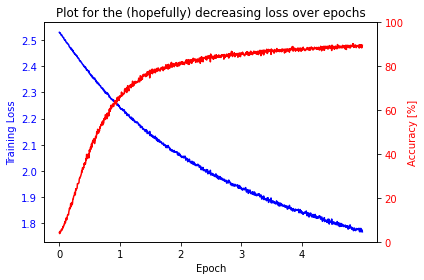

Epoch 0:   0%|                                                                              | 0/198 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: English
Model trained on 56283 sentences
Training set holds 50654
Test set holds 5629


Epoch 4: 100%|██████████████████████████████████████████| 198/198 [01:45<00:00,  1.87batch/s, accuracy=89.4, loss=1.33]


Accuracy is 87.86647719842729


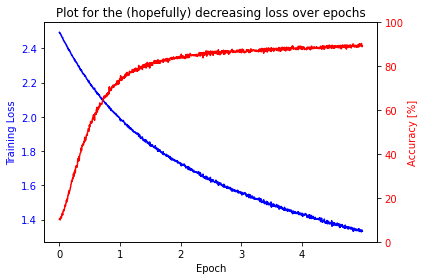

Epoch 0:   0%|                                                                              | 0/198 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: English
Model trained on 56283 sentences
Training set holds 50654
Test set holds 5629


Epoch 4: 100%|██████████████████████████████████████████| 198/198 [03:27<00:00,  1.05s/batch, accuracy=91.9, loss=1.74]


Accuracy is 90.4225548571578


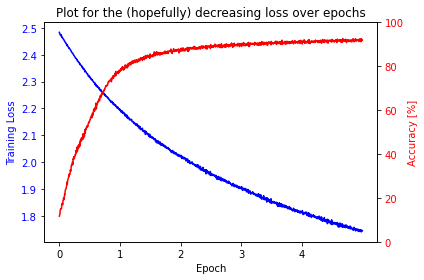

In [15]:
typ_dict = {"Vanilla": 1, "GRU": 2, "Bi-Directional": 3}
baseline_dict = {}

for model_typ in typ_dict.keys():
    model = LSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx), tagset_size=len(tag2idx)-1, n_layers = 2, dropout = 0.25, rnn_type = typ_dict[model_typ])
    print('***Model info***')
    print('Model type:', model_typ)
    print('Model trained on language: English')
    print('Model trained on', len(sentences), 'sentences')
    print('Training set holds', len(X_train))
    print('Test set holds', len(X_test))
    model.fit(X_train, y_train)
    accuracy = model.score(model, X_test, y_test)
    print('Accuracy is', accuracy)
    baseline_dict[model_typ] = accuracy
    model.plot(X_train)
    del model

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: SUD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [00:41<00:00,  1.39batch/s, accuracy=77.3, loss=2.43]


Accuracy is -11.986383674187536% compared to baseline


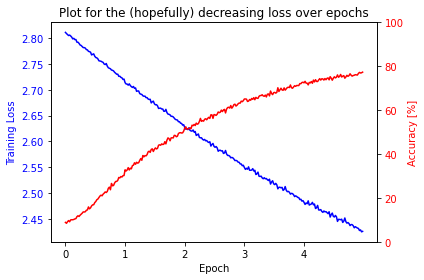

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [00:42<00:00,  1.34batch/s, accuracy=77.4, loss=2.48]


Accuracy is -13.482546114681085% compared to baseline


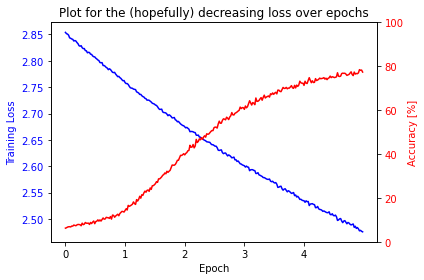

Epoch 0:   0%|                                                                               | 0/18 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Indonesian-GSD
Model trained on 4467 sentences
Training set holds 4477
Test set holds 557


Epoch 4: 100%|████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51batch/s, accuracy=43.6, loss=2.63]


Accuracy is -45.832257646308776% compared to baseline


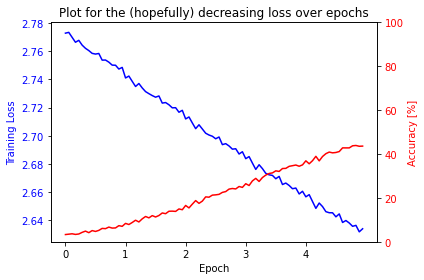

Epoch 0:   1%|▋                                            | 1/70 [00:00<00:11,  6.10batch/s, accuracy=3.99, loss=2.89]

***Model info***
Model type: Vanilla
Model trained on language: UD_Polish-PDB
Model trained on 17688 sentences
Training set holds 17722
Test set holds 2215


Epoch 4: 100%|████████████████████████████████████████████| 70/70 [00:23<00:00,  2.99batch/s, accuracy=71.7, loss=2.54]


Accuracy is -20.01133670315386% compared to baseline


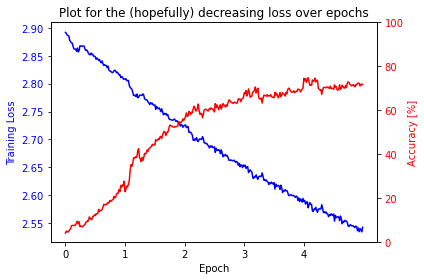

Epoch 0:   0%|                                                                               | 0/33 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Portuguese-Bosque
Model trained on 8152 sentences
Training set holds 8328
Test set holds 476


Epoch 4: 100%|████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11batch/s, accuracy=63.2, loss=2.66]


Accuracy is -27.544699158045674% compared to baseline


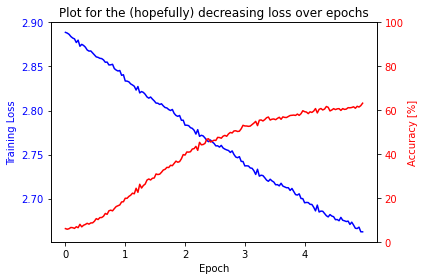

Epoch 0:   0%|                                                                               | 0/15 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Romanian-SiMoNERo
Model trained on 3743 sentences
Training set holds 3747
Test set holds 491


Epoch 4: 100%|████████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/batch, accuracy=27.3, loss=2.67]


Accuracy is -63.68473695868566% compared to baseline


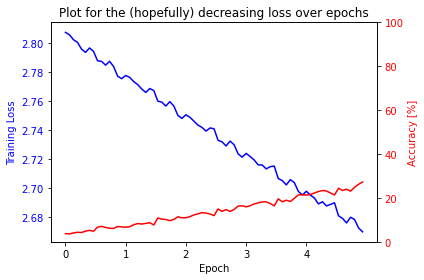

Epoch 0:   3%|█▎                                           | 1/34 [00:00<00:04,  7.81batch/s, accuracy=1.28, loss=2.96]

***Model info***
Model type: Vanilla
Model trained on language: UD_Slovak-SNK
Model trained on 8224 sentences
Training set holds 8483
Test set holds 1061


Epoch 4: 100%|████████████████████████████████████████████| 34/34 [00:05<00:00,  6.30batch/s, accuracy=32.9, loss=2.78]


Accuracy is -63.49878811645501% compared to baseline


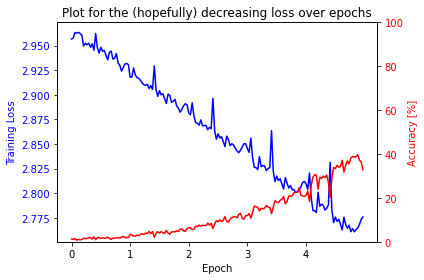

Epoch 0:   0%|                                                                                | 0/9 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Slovenian-SST
Model trained on 1484 sentences
Training set holds 2078
Test set holds 1110


Epoch 4: 100%|███████████████████████████████████████████████| 9/9 [00:02<00:00,  3.83batch/s, accuracy=26.5, loss=2.7]


Accuracy is -66.76403842978853% compared to baseline


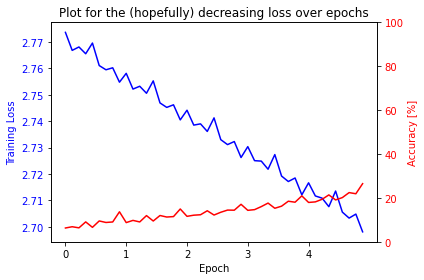

Epoch 0:   0%|                                                                               | 0/56 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Spanish-GSD
Model trained on 14182 sentences
Training set holds 14187
Test set holds 426


Epoch 4: 100%|████████████████████████████████████████████| 56/56 [00:46<00:00,  1.20batch/s, accuracy=77.2, loss=2.53]


Accuracy is -13.473947479965602% compared to baseline


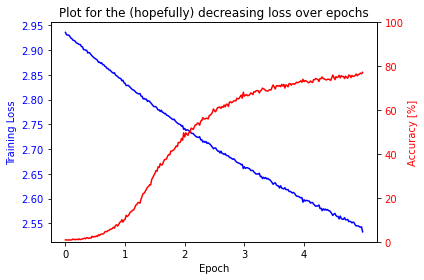

Epoch 0:   0%|                                                                               | 0/13 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Swedish-LinES
Model trained on 3152 sentences
Training set holds 3176
Test set holds 1035


Epoch 4: 100%|████████████████████████████████████████████| 13/13 [00:05<00:00,  2.54batch/s, accuracy=22.5, loss=2.74]


Accuracy is -68.0211371291562% compared to baseline


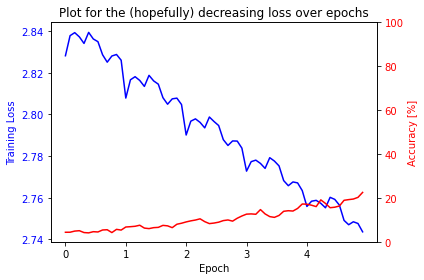

Epoch 0:   5%|██▎                                           | 3/61 [00:00<00:01, 29.14batch/s, accuracy=8.96, loss=2.7]

***Model info***
Model type: Vanilla
Model trained on language: UD_Turkish-Tourism
Model trained on 14754 sentences
Training set holds 15375
Test set holds 2193


Epoch 4: 100%|████████████████████████████████████████████| 61/61 [00:03<00:00, 15.27batch/s, accuracy=74.3, loss=2.39]


Accuracy is -0.57882611184381% compared to baseline


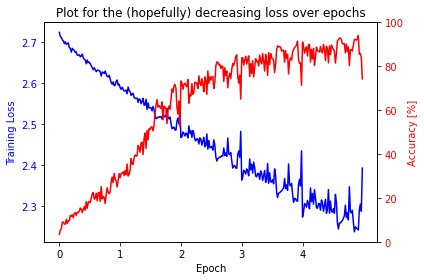

Epoch 0:  17%|███████▋                                      | 1/6 [00:00<00:00,  6.90batch/s, accuracy=12.8, loss=2.61]

***Model info***
Model type: Vanilla
Model trained on language: UD_Vietnamese-VTB
Model trained on 1396 sentences
Training set holds 1400
Test set holds 800


Epoch 4: 100%|██████████████████████████████████████████████| 6/6 [00:00<00:00,  6.11batch/s, accuracy=29.3, loss=2.55]


Accuracy is -59.51905897300131% compared to baseline


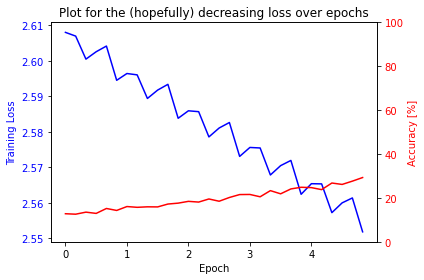

Epoch 0:   0%|                                                                                | 0/2 [00:00<?, ?batch/s]

***Model info***
Model type: Vanilla
Model trained on language: UD_Welsh-CCG
Model trained on 469 sentences
Training set holds 469
Test set holds 953


Epoch 4: 100%|██████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12batch/s, accuracy=7.57, loss=2.76]


Accuracy is -82.03035549076832% compared to baseline


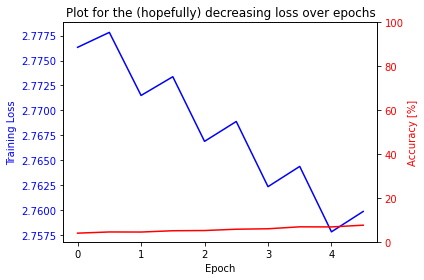

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: SUD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [00:38<00:00,  1.48batch/s, accuracy=78.2, loss=2.18]


Accuracy is -11.299878539144288% compared to baseline


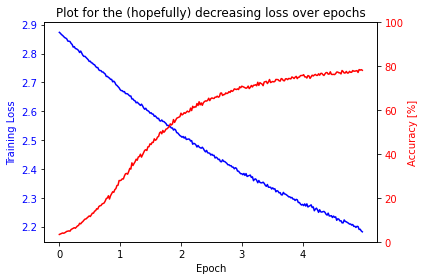

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [00:37<00:00,  1.54batch/s, accuracy=77.3, loss=2.15]


Accuracy is -11.941091013641511% compared to baseline


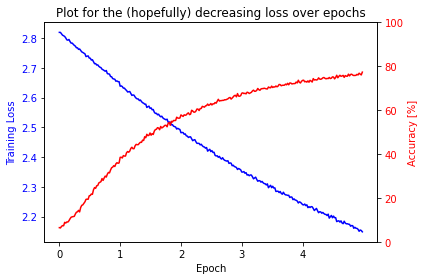

Epoch 0:   0%|                                                                               | 0/18 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Indonesian-GSD
Model trained on 4467 sentences
Training set holds 4477
Test set holds 557


Epoch 4: 100%|█████████████████████████████████████████████| 18/18 [00:10<00:00,  1.72batch/s, accuracy=50.6, loss=2.5]


Accuracy is -40.516623472734636% compared to baseline


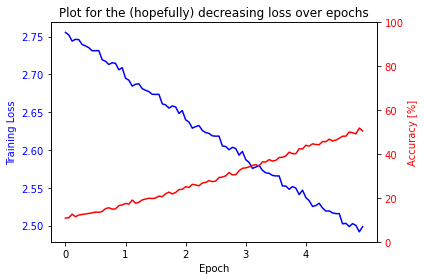

Epoch 0:   0%|                                                                               | 0/70 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Polish-PDB
Model trained on 17688 sentences
Training set holds 17722
Test set holds 2215


Epoch 4: 100%|████████████████████████████████████████████| 70/70 [00:20<00:00,  3.43batch/s, accuracy=71.4, loss=2.33]


Accuracy is -19.000029033547023% compared to baseline


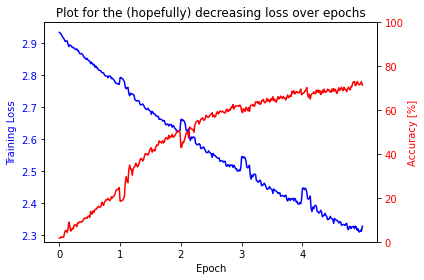

Epoch 0:   0%|                                                                               | 0/33 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Portuguese-Bosque
Model trained on 8152 sentences
Training set holds 8328
Test set holds 476


Epoch 4: 100%|████████████████████████████████████████████| 33/33 [00:23<00:00,  1.43batch/s, accuracy=66.5, loss=2.43]


Accuracy is -23.294944218343247% compared to baseline


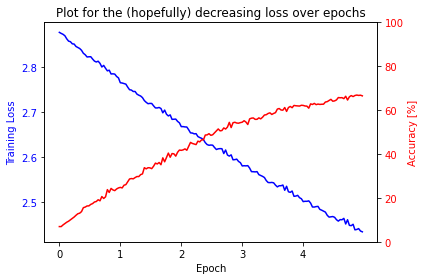

Epoch 0:   0%|                                                                               | 0/15 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Romanian-SiMoNERo
Model trained on 3743 sentences
Training set holds 3747
Test set holds 491


Epoch 4: 100%|████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/batch, accuracy=40.7, loss=2.55]


Accuracy is -51.5896767586252% compared to baseline


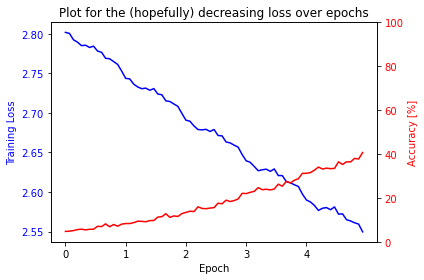

Epoch 0:   3%|█▎                                           | 1/34 [00:00<00:03,  9.01batch/s, accuracy=4.56, loss=2.92]

***Model info***
Model type: GRU
Model trained on language: UD_Slovak-SNK
Model trained on 8224 sentences
Training set holds 8483
Test set holds 1061


Epoch 4: 100%|████████████████████████████████████████████| 34/34 [00:04<00:00,  7.25batch/s, accuracy=52.1, loss=2.59]


Accuracy is -46.938140990178894% compared to baseline


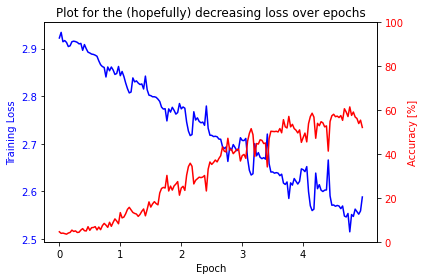

Epoch 0:  11%|█████                                         | 1/9 [00:00<00:01,  6.17batch/s, accuracy=4.81, loss=2.78]

***Model info***
Model type: GRU
Model trained on language: UD_Slovenian-SST
Model trained on 1484 sentences
Training set holds 2078
Test set holds 1110


Epoch 4: 100%|██████████████████████████████████████████████| 9/9 [00:01<00:00,  5.13batch/s, accuracy=26.9, loss=2.62]


Accuracy is -57.032727822491196% compared to baseline


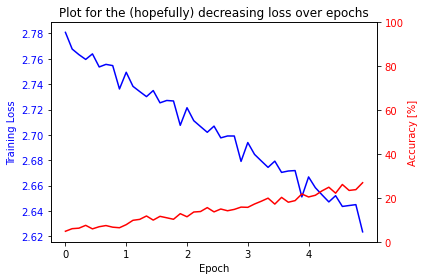

Epoch 0:   0%|                                                                               | 0/56 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Spanish-GSD
Model trained on 14182 sentences
Training set holds 14187
Test set holds 426


Epoch 4: 100%|████████████████████████████████████████████| 56/56 [00:43<00:00,  1.30batch/s, accuracy=75.5, loss=2.22]


Accuracy is -13.577735044681475% compared to baseline


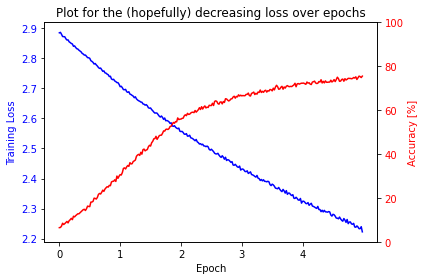

Epoch 0:   0%|                                                     | 0/13 [00:00<?, ?batch/s, accuracy=6.69, loss=2.84]

***Model info***
Model type: GRU
Model trained on language: UD_Swedish-LinES
Model trained on 3152 sentences
Training set holds 3176
Test set holds 1035


Epoch 4: 100%|████████████████████████████████████████████| 13/13 [00:05<00:00,  2.50batch/s, accuracy=42.6, loss=2.62]


Accuracy is -50.541538984940175% compared to baseline


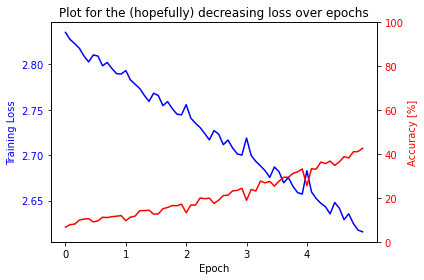

Epoch 0:   5%|██▏                                          | 3/61 [00:00<00:02, 27.52batch/s, accuracy=4.29, loss=2.74]

***Model info***
Model type: GRU
Model trained on language: UD_Turkish-Tourism
Model trained on 14754 sentences
Training set holds 15375
Test set holds 2193


Epoch 4: 100%|█████████████████████████████████████████████| 61/61 [00:03<00:00, 18.82batch/s, accuracy=56.8, loss=2.2]


Accuracy is -2.225099241807399% compared to baseline


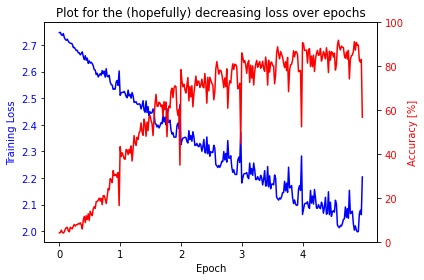

Epoch 0:  17%|███████▋                                      | 1/6 [00:00<00:00,  7.46batch/s, accuracy=4.43, loss=2.66]

***Model info***
Model type: GRU
Model trained on language: UD_Vietnamese-VTB
Model trained on 1396 sentences
Training set holds 1400
Test set holds 800


Epoch 4: 100%|██████████████████████████████████████████████| 6/6 [00:00<00:00,  7.08batch/s, accuracy=17.2, loss=2.56]


Accuracy is -69.99947594372215% compared to baseline


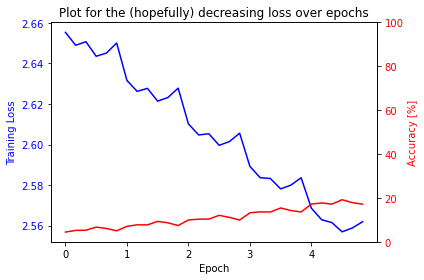

Epoch 0:   0%|                                                                                | 0/2 [00:00<?, ?batch/s]

***Model info***
Model type: GRU
Model trained on language: UD_Welsh-CCG
Model trained on 469 sentences
Training set holds 469
Test set holds 953


Epoch 4: 100%|██████████████████████████████████████████████| 2/2 [00:00<00:00,  2.42batch/s, accuracy=11.8, loss=2.73]


Accuracy is -78.81761914696733% compared to baseline


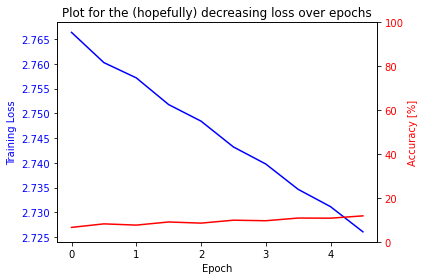

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: SUD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [01:18<00:00,  1.37s/batch, accuracy=77.6, loss=2.48]


Accuracy is -15.041227741642402% compared to baseline


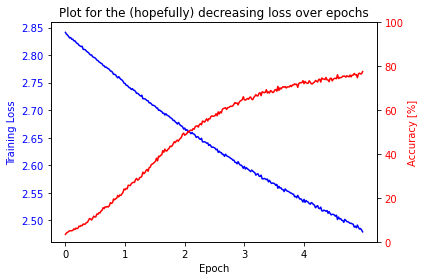

Epoch 0:   0%|                                                                               | 0/57 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_French-GSD
Model trained on 14447 sentences
Training set holds 14449
Test set holds 416


Epoch 4: 100%|████████████████████████████████████████████| 57/57 [01:16<00:00,  1.35s/batch, accuracy=79.3, loss=2.42]


Accuracy is -13.185597701809513% compared to baseline


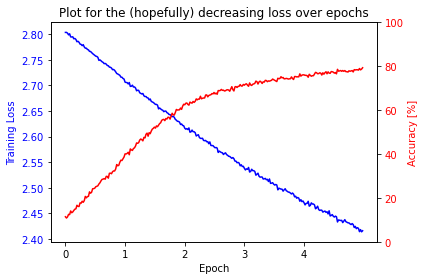

Epoch 0:   0%|                                                                               | 0/18 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Indonesian-GSD
Model trained on 4467 sentences
Training set holds 4477
Test set holds 557


Epoch 4: 100%|████████████████████████████████████████████| 18/18 [00:22<00:00,  1.26s/batch, accuracy=53.1, loss=2.62]


Accuracy is -41.59274931594287% compared to baseline


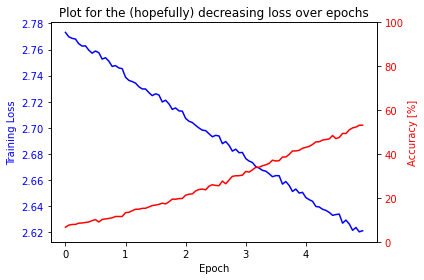

Epoch 0:   0%|                                                                               | 0/70 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Polish-PDB
Model trained on 17688 sentences
Training set holds 17722
Test set holds 2215


Epoch 4: 100%|████████████████████████████████████████████| 70/70 [00:43<00:00,  1.60batch/s, accuracy=73.5, loss=2.55]


Accuracy is -21.759844844461085% compared to baseline


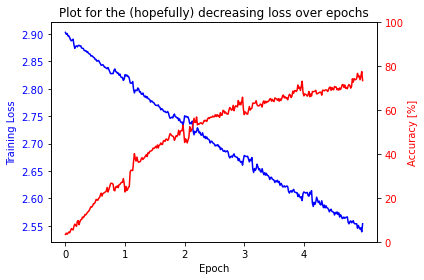

Epoch 0:   0%|                                                                               | 0/33 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Portuguese-Bosque
Model trained on 8152 sentences
Training set holds 8328
Test set holds 476


Epoch 4: 100%|████████████████████████████████████████████| 33/33 [00:51<00:00,  1.57s/batch, accuracy=52.3, loss=2.67]


Accuracy is -39.20749912903794% compared to baseline


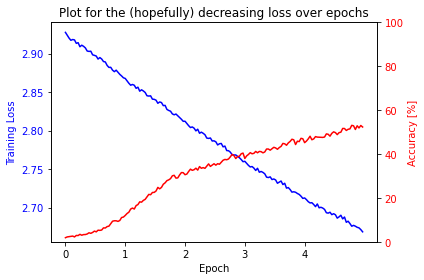

Epoch 0:   0%|                                                                               | 0/15 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Romanian-SiMoNERo
Model trained on 3743 sentences
Training set holds 3747
Test set holds 491


Epoch 4: 100%|██████████████████████████████████████████████| 15/15 [00:31<00:00,  2.10s/batch, accuracy=45, loss=2.63]


Accuracy is -43.34998751246292% compared to baseline


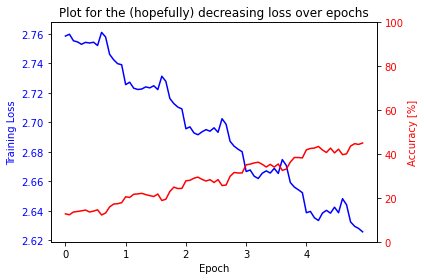

Epoch 0:   0%|                                                                               | 0/34 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Slovak-SNK
Model trained on 8224 sentences
Training set holds 8483
Test set holds 1061


Epoch 4: 100%|█████████████████████████████████████████████| 34/34 [00:09<00:00,  3.58batch/s, accuracy=50.7, loss=2.7]


Accuracy is -48.51413396959312% compared to baseline


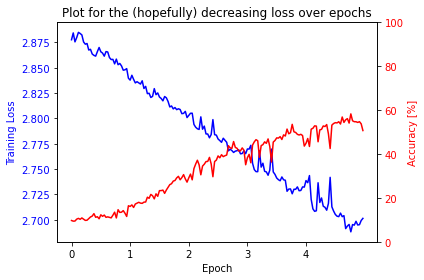

Epoch 0:   0%|                                                                                | 0/9 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Slovenian-SST
Model trained on 1484 sentences
Training set holds 2078
Test set holds 1110


Epoch 4: 100%|███████████████████████████████████████████████| 9/9 [00:03<00:00,  2.61batch/s, accuracy=26.9, loss=2.7]


Accuracy is -65.32020837687823% compared to baseline


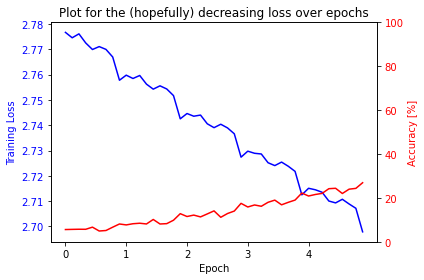

Epoch 0:   0%|                                                                               | 0/56 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Spanish-GSD
Model trained on 14182 sentences
Training set holds 14187
Test set holds 426


Epoch 4: 100%|████████████████████████████████████████████| 56/56 [01:25<00:00,  1.52s/batch, accuracy=80.5, loss=2.53]


Accuracy is -13.867569938269739% compared to baseline


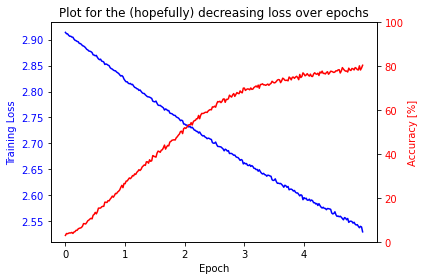

Epoch 0:   0%|                                                                               | 0/13 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Swedish-LinES
Model trained on 3152 sentences
Training set holds 3176
Test set holds 1035


Epoch 4: 100%|████████████████████████████████████████████| 13/13 [00:09<00:00,  1.42batch/s, accuracy=27.1, loss=2.75]


Accuracy is -64.60756133003059% compared to baseline


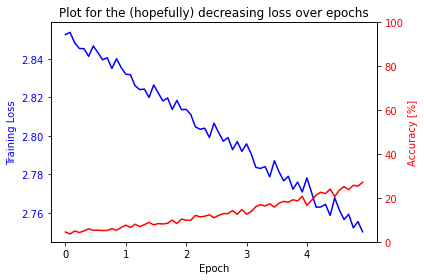

Epoch 0:   0%|                                                     | 0/61 [00:00<?, ?batch/s, accuracy=2.07, loss=2.73]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Turkish-Tourism
Model trained on 14754 sentences
Training set holds 15375
Test set holds 2193


Epoch 4: 100%|████████████████████████████████████████████| 61/61 [00:06<00:00,  9.50batch/s, accuracy=72.8, loss=2.45]


Accuracy is 0.3419951477494436% compared to baseline


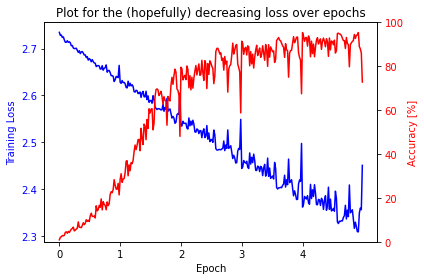

Epoch 0:   0%|                                                                                | 0/6 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Vietnamese-VTB
Model trained on 1396 sentences
Training set holds 1400
Test set holds 800


Epoch 4: 100%|██████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03batch/s, accuracy=15.3, loss=2.58]


Accuracy is -77.69984469404613% compared to baseline


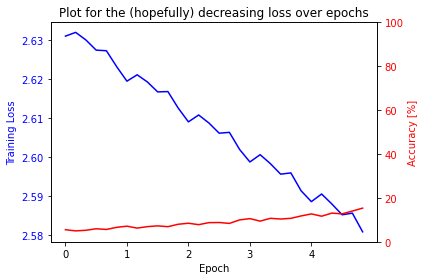

Epoch 0:   0%|                                                                                | 0/2 [00:00<?, ?batch/s]

***Model info***
Model type: Bi-Directional
Model trained on language: UD_Welsh-CCG
Model trained on 469 sentences
Training set holds 469
Test set holds 953


Epoch 4: 100%|██████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34batch/s, accuracy=5.25, loss=2.78]


Accuracy is -85.01636809797886% compared to baseline


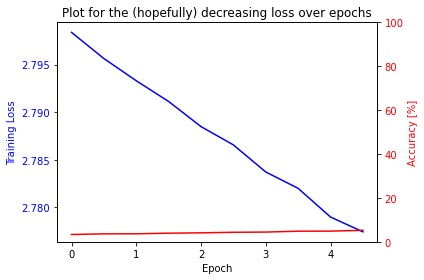

In [16]:
for model_typ in typ_dict.keys():
    X_train, y_train, X_test, y_test = [], [], [], []
    sentences = []
    for language in training_data.keys():

        X_train = list(training_data[language])[0]
        y_train = list(training_data[language])[1]

        X_test = list(test_data[language])[0]
        y_test = list(test_data[language])[1]

        # Formating sentences appropriately
        for i in range(len(X_train)):
            sentences.append([tuple(zip(X_train[i], y_train[i]))])
            sentences[i] = list(sentences[i][0])

        sentences = [sentence for sentence in sentences if len(sentence) > 2] # Removing sort sentences

        tokens = {token for sentence in X_train for token in sentence}
        idx2token = list(tokens)
        idx2token.insert(0, '<UNK>')
        idx2token.append('<PAD>')
        token2idx = {token:idx for idx, token in enumerate(idx2token)}

        tags = {tag for tags in y_train for tag in tags}
        idx2tag = list(tags)
        idx2tag.append('<PAD>')
        tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

        a, b = pad_and_encode(X_train[:5], y_train[:5])
        next(batch_iterator(X_train, y_train, batch_size=5))

        model = LSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx), tagset_size=len(tag2idx)-1, n_layers = 2, dropout = 0.25, rnn_type = typ_dict[model_typ])
        
        print('***Model info***')
        print('Model type:', model_typ)
        print('Model trained on language:', language)
        print('Model trained on', len(sentences), 'sentences')
        print('Training set holds', len(X_train))
        print('Test set holds', len(X_test))
        model.fit(X_train, y_train)
        accuracy = model.score(model, X_test, y_test)
        print('Accuracy is', str(accuracy - baseline_dict[model_typ]) + '% compared to baseline')
        model.plot(X_train)
        
        X_train, y_train, X_test, y_test = [], [], [], []
        sentences = []